In [81]:
import pandas as pd 
# !pip install findspark
# !pip install pyspark
# import findspark
import pyspark
import os
import glob
from glob import glob
# import random
from pyspark import SparkContext, SparkConf, SQLContext
#from pyspark.sql.functions import udf 
#from pyspark.sql.functions import desc 
#from pyspark.sql.functions import asc 
#import pyspark.sql.functions as F 
import numpy as np
from pyspark.sql import Window
from pyspark.sql.functions import isnan, when, count, col , median
from pyspark.sql.types import DateType
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [82]:
# findspark.init('C:\spark\spark-3.3.2-bin-hadoop2')

In [83]:
# create SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("Skin_cancer").getOrCreate()

In [84]:
spark

In [85]:
# create a Spark dataframe from .csv file
# automatically infer schema
# df = spark.read.csv('HAM10000_metadata', inferSchema=True, header=True)
df = spark.read.csv('s3://mybucket.rohit/HAM10000_metadata', inferSchema=True, header=True)

# Reading & Understanding the Data

In [86]:
# inspect infered schema
df.printSchema()

root
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)
 |-- dataset: string (nullable = true)



In [87]:
# # We can also define the schema manually.
# from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType , DoubleType

# # define schema

# manualSchema = StructType([
#     StructField("lesion_id", StringType(), True),
#     StructField("image_id", StringType(), True),
#     StructField("dx", StringType(), True),
#     StructField("dx_type", StringType(), True),
#     StructField("age", DoubleType(), True),
#     StructField("sex", StringType(), True),
#     StructField("localization", StringType(), True),
#     StructField("dataset", StringType(), True)
# ])


In [88]:
# df = spark.read.csv('HAM10000_metadata', inferSchema=True, header=True)

In [89]:
type(df)


pyspark.sql.dataframe.DataFrame

In [90]:
# Change the data type of the 'age' column to StringType
#df = df.withColumn("image", col("image").cast("integer"))

In [91]:
# df.printSchema()

In [92]:
# show first 5 rows
df.show(5)

+-----------+------------+---+-------+----+----+------------+------------+
|  lesion_id|    image_id| dx|dx_type| age| sex|localization|     dataset|
+-----------+------------+---+-------+----+----+------------+------------+
|HAM_0000118|ISIC_0027419|bkl|  histo|80.0|male|       scalp|vidir_modern|
|HAM_0000118|ISIC_0025030|bkl|  histo|80.0|male|       scalp|vidir_modern|
|HAM_0002730|ISIC_0026769|bkl|  histo|80.0|male|       scalp|vidir_modern|
|HAM_0002730|ISIC_0025661|bkl|  histo|80.0|male|       scalp|vidir_modern|
|HAM_0001466|ISIC_0031633|bkl|  histo|75.0|male|         ear|vidir_modern|
+-----------+------------+---+-------+----+----+------------+------------+
only showing top 5 rows



In [93]:
# By using the method .limit() and .toPandas(), we can convert a Spark DataFrame into a Pandas table display.
# visualize as Pandas table
df.limit(5).toPandas()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [94]:
# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_columns = len(df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 10015
Number of columns: 8


In [95]:
# Total number of duplicate records
df.count() - df.distinct().count()  

0

In [96]:
# A general statistical analysis of the numerical values of dataset (here : age)
df.describe().show()

+-------+-----------+------------+-----+--------+------------------+-------+---------------+-----------+
|summary|  lesion_id|    image_id|   dx| dx_type|               age|    sex|   localization|    dataset|
+-------+-----------+------------+-----+--------+------------------+-------+---------------+-----------+
|  count|      10015|       10015|10015|   10015|              9958|  10015|          10015|      10015|
|   mean|       null|        null| null|    null|51.863828077927295|   null|           null|       null|
| stddev|       null|        null| null|    null|16.968613692495342|   null|           null|       null|
|    min|HAM_0000000|ISIC_0024306|akiec|confocal|               0.0| female|        abdomen|  rosendahl|
|    max|HAM_0007628|ISIC_0034320| vasc|   histo|              85.0|unknown|upper extremity|vienna_dias|
+-------+-----------+------------+-----+--------+------------------+-------+---------------+-----------+



# Data Cleaning & Imputing Null values

In [97]:
# checking how many null values are present in each of the columns 

# creating a function to find null values for the dataframe

def null_values(df):
    for i in df.columns:
        print(i,(20-len(i))*"-",">",((df.filter(df[i].isNull()).count())))
        
# df['sex'].isNull().count()

In [98]:
null_values(df)

lesion_id ----------- > 0
image_id ------------ > 0
dx ------------------ > 0
dx_type ------------- > 0
age ----------------- > 57
sex ----------------- > 0
localization -------- > 0
dataset ------------- > 0


The feature 'age' consists of 57 null records. Thus, we need to replace them with the mean of 'age' since dropping 57 records would lead to loss of data.

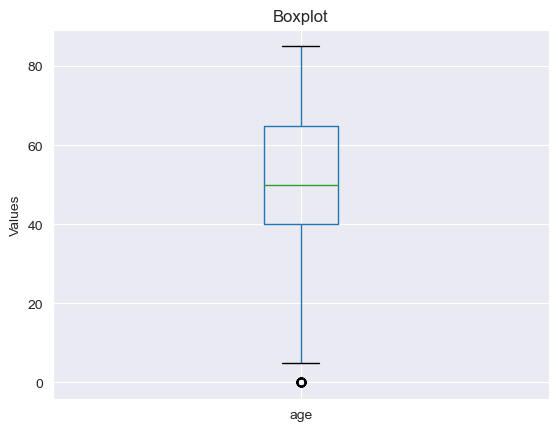

In [99]:
import matplotlib.pyplot as plt
# Convert PySpark DataFrame to pandas DataFrame

# Use pandas' plotting to create a boxplot
df.toPandas().boxplot(column=['age'])
plt.title('Boxplot')
plt.ylabel('Values')
plt.show()

In [100]:
from pyspark.sql.functions import isnan, when, count, col , mean
# Calculate the mean age
mean_age = df.select(mean(col('age'))).collect()[0][0]

# Fill missing age values with the calculated mean age
df = df.withColumn('age', when(col('age').isNull(), int(mean_age)).otherwise(col('age')))


In [101]:
null_values(df)

lesion_id ----------- > 0
image_id ------------ > 0
dx ------------------ > 0
dx_type ------------- > 0
age ----------------- > 0
sex ----------------- > 0
localization -------- > 0
dataset ------------- > 0


In [102]:
from pyspark.sql.functions import regexp_replace

l={ 'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

# creating a dictionary l that maps cell type codes to cell type names.


l=list(l.items())  # returns a list of key-value pairs,converts the dictionary to a list of tuples

for i in range(7):
    df=df.withColumn('cell_type', regexp_replace('dx', l[i][0], l[i][1]))
for i in range(7):
    df=df.withColumn('cell_type', regexp_replace('cell_type', l[i][0], l[i][1]))

In [103]:
df.show()

+-----------+------------+---+-------+----+------+---------------+------------+--------------------+
|  lesion_id|    image_id| dx|dx_type| age|   sex|   localization|     dataset|           cell_type|
+-----------+------------+---+-------+----+------+---------------+------------+--------------------+
|HAM_0000118|ISIC_0027419|bkl|  histo|80.0|  male|          scalp|vidir_modern|Benign keratosis-...|
|HAM_0000118|ISIC_0025030|bkl|  histo|80.0|  male|          scalp|vidir_modern|Benign keratosis-...|
|HAM_0002730|ISIC_0026769|bkl|  histo|80.0|  male|          scalp|vidir_modern|Benign keratosis-...|
|HAM_0002730|ISIC_0025661|bkl|  histo|80.0|  male|          scalp|vidir_modern|Benign keratosis-...|
|HAM_0001466|ISIC_0031633|bkl|  histo|75.0|  male|            ear|vidir_modern|Benign keratosis-...|
|HAM_0001466|ISIC_0027850|bkl|  histo|75.0|  male|            ear|vidir_modern|Benign keratosis-...|
|HAM_0002761|ISIC_0029176|bkl|  histo|60.0|  male|           face|vidir_modern|Benign kerat

In [104]:
# Save DataFrame to CSV
#df.write.csv('New_Metadata.csv', header=True, mode='overwrite') 
import boto3
s3_bucket_name = 'mybucket.rohit'
file_path_in_s3 = 's3://mybucket.rohit/file.csv'

csv_buffer = df.to_csv(index=False).encode()

# Initialize a boto3 S3 client
s3_client = boto3.client('s3')

# Upload the CSV data to S3
s3_client.put_object(Bucket=s3_bucket_name, Key=file_path_in_s3, Body=csv_buffer)

In [ ]:
s3_bucket_name = 'mybucket.rohit'
output_file_path = 's3://mybucket.rohit/file.csv'

output_s3_path = f"s3://{s3_bucket_name}/{output_file_path}"
df.write.csv(output_s3_path, header=True, mode="overwrite")



# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in data analysis that involves examining and understanding the structure, patterns, and characteristics of a dataset. PySpark is a Python library for Apache Spark, a powerful framework for distributed data processing. PySpark enables you to perform EDA on large datasets in a distributed and efficient manner.

We can do EDA in spark using Matplot and Seaboarn. We can do it use dataframe in Pyspark for that so first convert RDD to pandas dataframe

# Univariate
Univariate Exploratory Data Analysis (EDA) involves analyzing and visualizing individual variables or features of a dataset in isolation. It helps you understand the distribution, central tendency, spread, and potential outliers of each variable. 

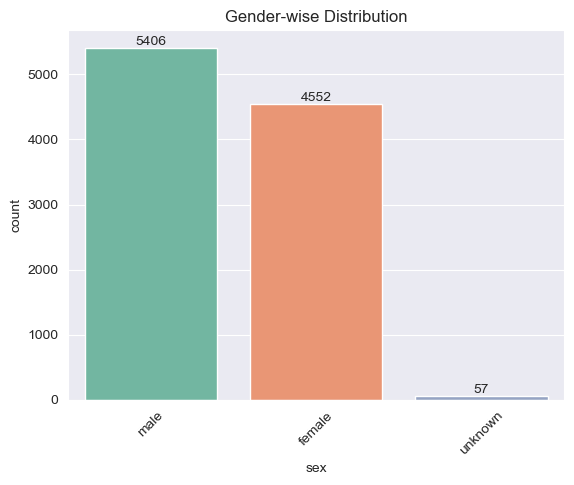

In [105]:
ax = sns.countplot(x='sex',data=df.toPandas(), palette='Set2')
sns.set_style('darkgrid')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

It seems that a larger number of men are showing symptoms of skin cancer. However, there isn't a clear difference in the likelihood of being affected by gender.

# Cell Types

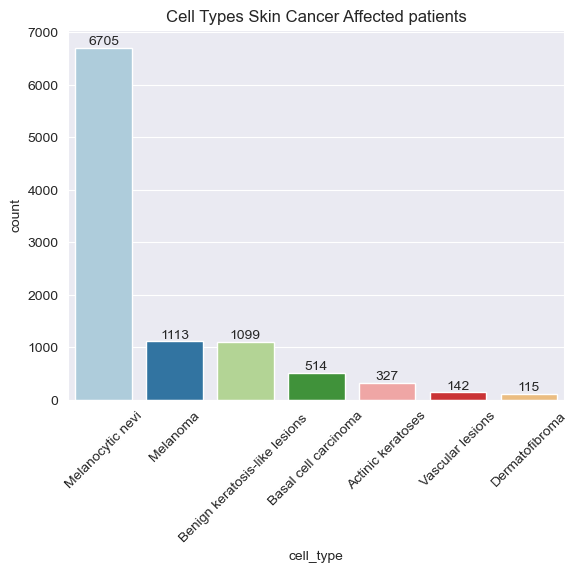

In [106]:
ax = sns.countplot(x='cell_type',data=df.toPandas(), order = df.toPandas()['cell_type'].value_counts().index, palette = 'Paired')
sns.set_style('darkgrid')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

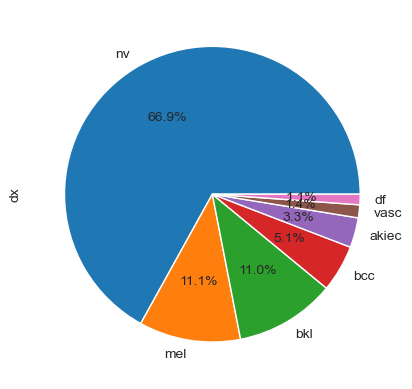

In [107]:
df.toPandas()['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

# __Type of skin disease:__

- nv: Melanocytic nevi - 69.9%
- mel: Melanoma - 11.1 %
- bkl: Benign keratosis-like lesions - 11.0%
- bcc: Basal cell carcinoma - 5.1%
- akiec: Actinic keratoses- 3.3%
- vasc: Vascular lesions-1.4%
- df: Dermatofibroma - 1.1

### Note:- 
- Melanocytic nevi skin disease is most likely to cause compare to others.
- Melanoma and benign keratosis-like lesions are not as widespread as Melanocytic nevi.
- Remaining types of skin issues caused by viruses are also very less to be occured.

# Test Perform for detecting skin cancer

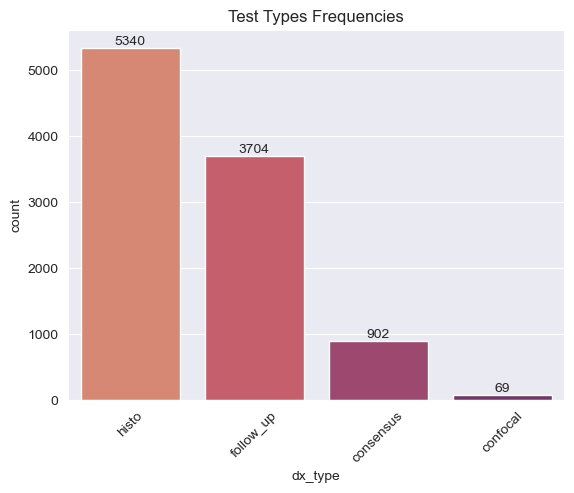

In [108]:
ax = sns.countplot(x='dx_type',data=df.toPandas(), order = df.toPandas()['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Test Types Frequencies')
plt.xticks(rotation=45)
plt.show()

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).

# Body Part Location

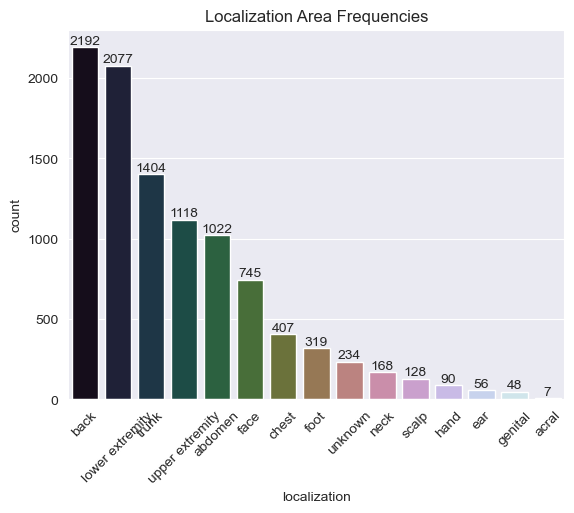

In [109]:
ax = sns.countplot(x='localization',data=df.toPandas(), order = df.toPandas()['localization'].value_counts().index, palette = 'cubehelix')
sns.set_style('darkgrid')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

# Note :
We can infer that most affected areas are back, lower extremity or trunk etc.
The significance we take out of it is that there are more chances to have skin disease at area which get swaty easily.

# Age

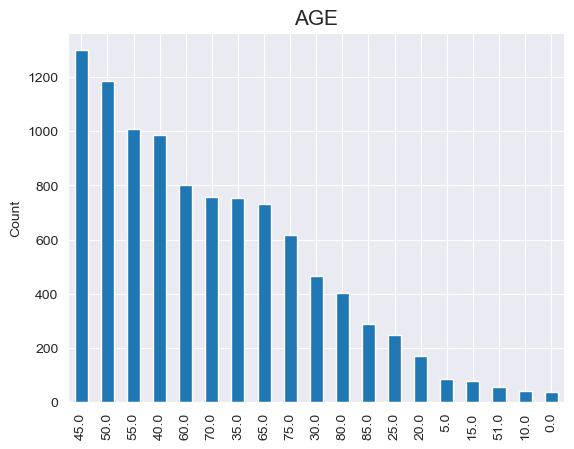

In [110]:
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df.toPandas()['age'].value_counts().plot.bar()
plt.show()

 Skin diseases are found to be maximum in people who are in age group of 40 to 50. There are very less chance to have skin dieases at age of 10 or below. We also observe that the probability of having skin disease increases with the increase in age.

# Bivarient

Bivariate Exploratory Data Analysis (EDA) involves analyzing the relationship between two variables in a dataset. This analysis helps you understand how two variables interact, correlate, or influence each other.

# Genderwise Testing type

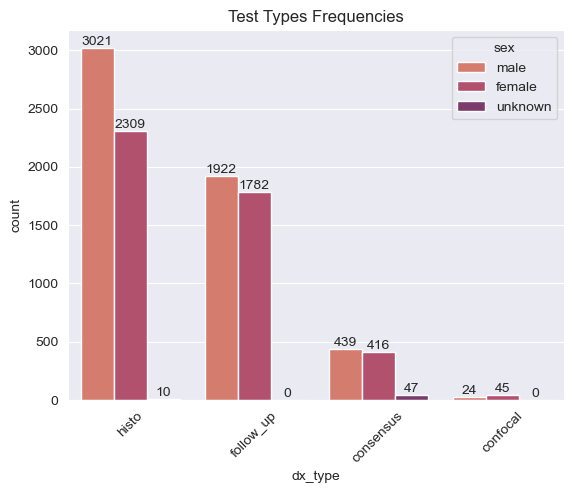

In [111]:
ax = sns.countplot(x='dx_type',hue='sex', data=df.toPandas(), order = df.toPandas()['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Test Types Frequencies')
plt.xticks(rotation=45)
plt.show()

Histopathology (histo) test will be more effective while finding skin cancer in male.
Other test are ve lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).

# Gender vs Cell type

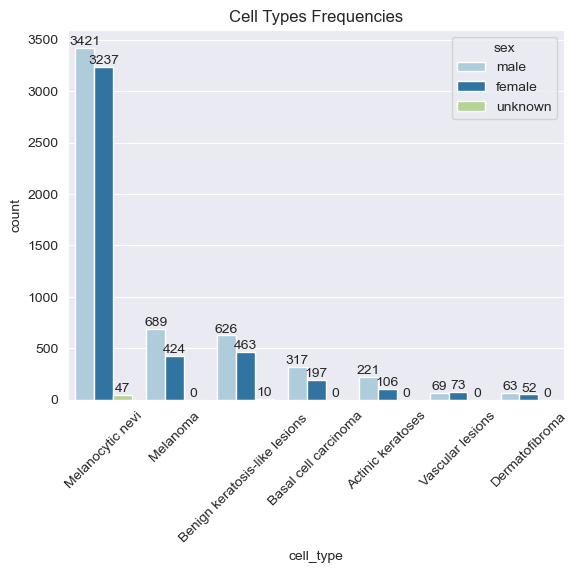

In [112]:
ax = sns.countplot(x='cell_type',hue='sex', data=df.toPandas(), order = df.toPandas()['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

It seems for every skin type cancer, majority of males are victims.

# Genderwise localization distribution

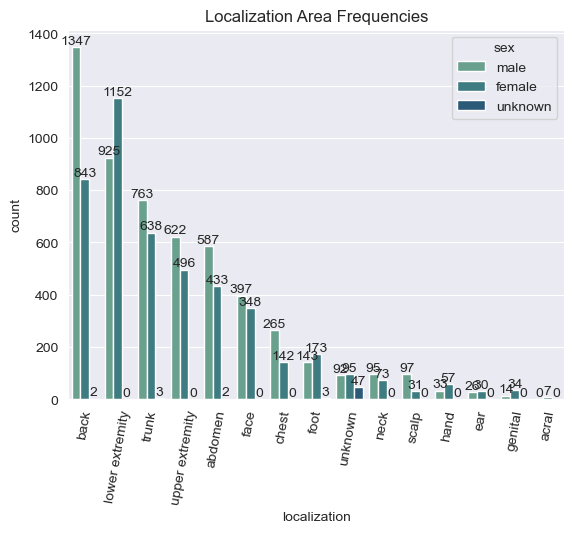

In [113]:
figsize=(20,8)
ax = sns.countplot(x='localization',hue='sex', data=df.toPandas(), order = df.toPandas()['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=80)
plt.show()

Back are is the most affected among people and more prominent in men.
Infection on Lower extremity of the body is more visible in women.
Some unknown regions also show infections and it's visible in men, women and other genders.
The acral surfaces show the least infection cases that too in female only. Other gender groups don't show this kind of infection.

# Genderwise Age didtribution

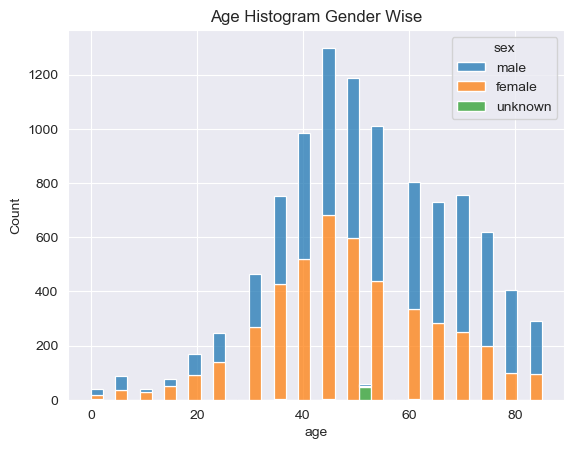

In [114]:
ax = sns.histplot(data=df.toPandas(), x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

From above, we can infer that there is a generally similar number of males and females getting infected within a specific age group, with only slight differences.

# Cell Type vs Age

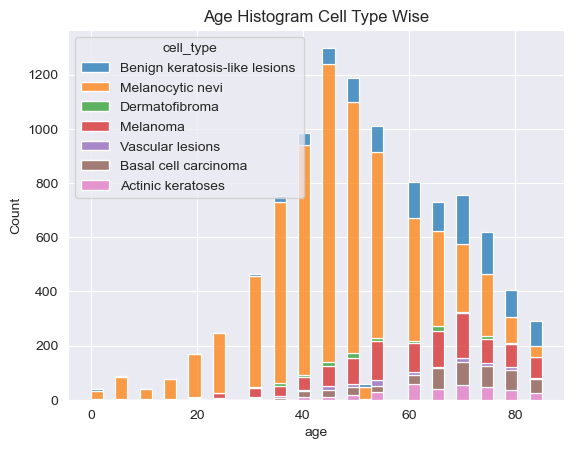

In [115]:

ax = sns.histplot(data=df.toPandas(), x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

In every age group, the majority of cases involve skin cancer cells of the Melanocytic nevi type, with noticeable instances of the Melanoma cell type and benign keratosis-like lesions.

# Localize area vs age

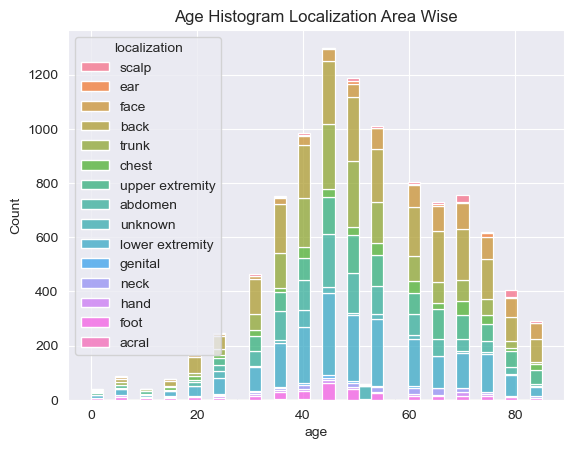

In [116]:
ax = sns.histplot(data=df.toPandas(), x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

In [117]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x000001CEA92EB0A0>>

# END